<a href="https://colab.research.google.com/github/divyagunde16/64061_AML/blob/main/Assignment_3_G11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Deep learning for timeseries**

**Different kinds of timeseries tasks**

**A temperature-forecasting example**

In [8]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-08 00:19:48--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.226.40, 16.182.65.80, 52.216.136.133, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.226.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  6.53MB/s    in 2.0s    

2024-04-08 00:19:51 (6.53 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Inspecting the data of the Jena weather dataset**



In [9]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**



In [10]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [11]:
temperature[:5]

array([-8.02, -8.41, -8.51, -8.31, -8.27])

In [12]:
import pandas as pd
view = pd.DataFrame(temperature)
view.describe()

,0
count,420451.000000
mean,9.448567
std,8.423685
min,-23.010000
25%,3.360000
50%,9.410000
75%,15.470000
max,37.280000


**Plotting the temperature timeseries**

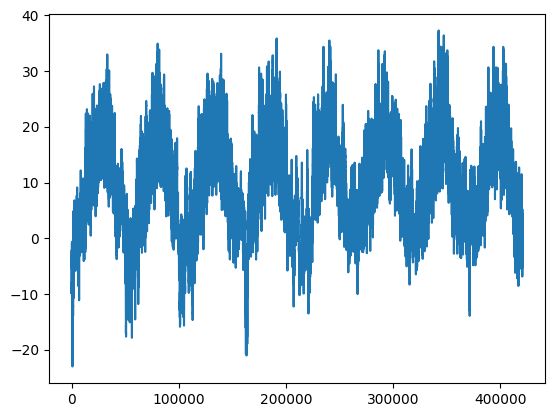

In [13]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

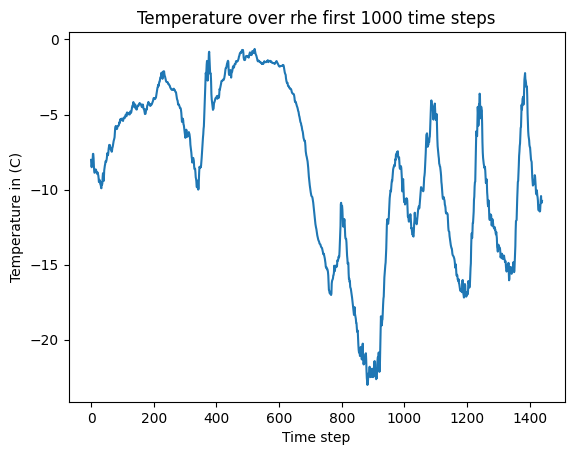

In [14]:
plt.plot(range(1440), temperature[:1440])

plt.xlabel("Time step")
plt.ylabel("Temperature in (C)")
plt.title("Temperature over rhe first 1000 time steps")
plt.show()

**Computing the number of samples we'll use for each data split**



In [15]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


**<h3>Preparing the data</h3>**

**Normalizing the data**

In [16]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [17]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [18]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [19]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


**<h4>A common-sense, non-machine-learning baseline</h4>**

**Computing the common-sense baseline MAE**

In [20]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


**<h3>Let's try a basic machine-learning model</h3>**
**Training and evaluating a densely connected model**

In [21]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 13s 14ms/step - loss: 13.8142 - mae: 2.8643 - val_loss: 10.4608 - val_mae: 2.5569
Epoch 2/10
819/819 [==============================] - 11s 14ms/step - loss: 9.3297 - mae: 2.4015 - val_loss: 11.2550 - val_mae: 2.6610
Epoch 3/10
819/819 [==============================] - 11s 14ms/step - loss: 8.4168 - mae: 2.2843 - val_loss: 12.5869 - val_mae: 2.7988
Epoch 4/10
819/819 [==============================] - 12s 14ms/step - loss: 7.9121 - mae: 2.2171 - val_loss: 11.4535 - val_mae: 2.6711
Epoch 5/10
819/819 [==============================] - 11s 13ms/step - loss: 7.5627 - mae: 2.1718 - val_loss: 11.0077 - val_mae: 2.6172
Epoch 6/10
819/819 [==============================] - 11s 13ms/step - loss: 7.2869 - mae: 2.1343 - val_loss: 10.8137 - val_mae: 2.5855
Epoch 7/10
819/819 [==============================] - 11s 13ms/step - loss: 7.0671 - mae: 2.1011 - val_loss: 10.8811 - val_mae: 2.5979
Epoch 8/10
819/819 [==============================] - 

In [22]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(64, activation="relu")(x) # Tried different dense units of 8, 32, 64 apart from 16 which is given in actual code
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 12s 14ms/step - loss: 12.7730 - mae: 2.7678 - val_loss: 12.4039 - val_mae: 2.7890
Epoch 2/10
819/819 [==============================] - 11s 14ms/step - loss: 8.6801 - mae: 2.3152 - val_loss: 9.8516 - val_mae: 2.4658
Epoch 3/10
819/819 [==============================] - 11s 14ms/step - loss: 7.4891 - mae: 2.1492 - val_loss: 10.8361 - val_mae: 2.5893
Epoch 4/10
819/819 [==============================] - 11s 13ms/step - loss: 6.7717 - mae: 2.0466 - val_loss: 13.0996 - val_mae: 2.8605
Epoch 5/10
819/819 [==============================] - 11s 14ms/step - loss: 6.2321 - mae: 1.9633 - val_loss: 10.8158 - val_mae: 2.5824
Epoch 6/10
819/819 [==============================] - 11s 14ms/step - loss: 5.8260 - mae: 1.8997 - val_loss: 10.8652 - val_mae: 2.5937
Epoch 7/10
819/819 [==============================] - 11s 14ms/step - loss: 5.4779 - mae: 1.8425 - val_loss: 13.0084 - val_mae: 2.8387
Epoch 8/10
819/819 [==============================] - 1

In [23]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten_1 (Flatten)         (None, 1680)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                107584    
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 107649 (420.50 KB)
Trainable params: 107649 (420.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Plotting results**

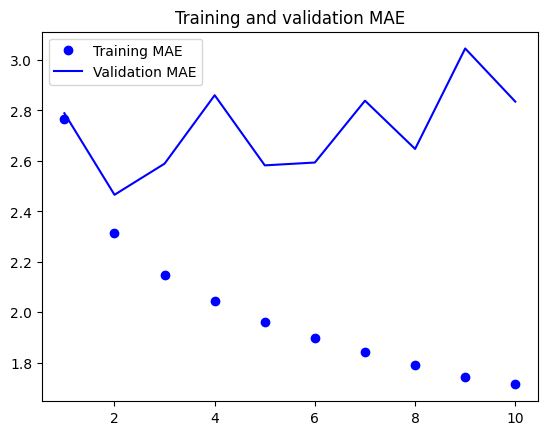

In [24]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Let's try a 1D convolutional model**


In [25]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
conv_x = layers.Conv1D(8, 24, activation="relu")(inputs)
conv_x = layers.MaxPooling1D(2)(conv_x)
conv_x = layers.Conv1D(8, 12, activation="relu")(conv_x)
conv_x = layers.MaxPooling1D(2)(conv_x)
conv_x = layers.Conv1D(8, 6, activation="relu")(conv_x)
conv_x = layers.GlobalAveragePooling1D()(conv_x)
outputs = layers.Dense(1)(conv_x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.conv_x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.conv_x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 15s 16ms/step - loss: 22.1177 - mae: 3.6712 - val_loss: 16.2495 - val_mae: 3.1734
Epoch 2/10
819/819 [==============================] - 12s 15ms/step - loss: 15.3976 - mae: 3.1114 - val_loss: 15.9620 - val_mae: 3.1727
Epoch 3/10
819/819 [==============================] - 12s 15ms/step - loss: 14.3613 - mae: 3.0042 - val_loss: 15.6863 - val_mae: 3.1444
Epoch 4/10
819/819 [==============================] - 12s 15ms/step - loss: 13.5870 - mae: 2.9213 - val_loss: 15.5898 - val_mae: 3.1009
Epoch 5/10
819/819 [==============================] - 12s 15ms/step - loss: 12.9138 - mae: 2.8461 - val_loss: 14.1066 - val_mae: 2.9436
Epoch 6/10
819/819 [==============================] - 11s 14ms/step - loss: 12.3847 - mae: 2.7831 - val_loss: 14.9282 - val_mae: 3.0529
Epoch 7/10
819/819 [==============================] - 11s 14ms/step - loss: 11.9615 - mae: 2.7309 - val_loss: 15.3528 - val_mae: 3.0703
Epoch 8/10
819/819 [============================

In [26]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 conv1d (Conv1D)             (None, 97, 8)             2696      
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 8)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 37, 8)             776       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 18, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 13, 8)             392 

**<h3>A first recurrent baseline</h3>**
**A simple LSTM-based model**

In [27]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 17s 19ms/step - loss: 43.6859 - mae: 4.8081 - val_loss: 13.0499 - val_mae: 2.7453
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 11.0795 - mae: 2.5840 - val_loss: 9.9770 - val_mae: 2.4488
Epoch 3/10
819/819 [==============================] - 12s 15ms/step - loss: 9.7480 - mae: 2.4375 - val_loss: 10.4237 - val_mae: 2.4635
Epoch 4/10
819/819 [==============================] - 12s 15ms/step - loss: 9.3784 - mae: 2.3904 - val_loss: 9.9946 - val_mae: 2.4373
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 9.0832 - mae: 2.3473 - val_loss: 9.9537 - val_mae: 2.4353
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 8.8392 - mae: 2.3130 - val_loss: 9.7423 - val_mae: 2.4102
Epoch 7/10
819/819 [==============================] - 12s 15ms/step - loss: 8.6534 - mae: 2.2878 - val_loss: 11.9105 - val_mae: 2.5416
Epoch 8/10
819/819 [==============================] - 15s

**<h3>Understanding recurrent neural networks</h3>**
**NumPy implementation of a simple RNN**

In [28]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

**<h3>A recurrent layer in Keras</h3>**
**An RNN layer that can process sequences of any length**

In [29]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [30]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [31]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [32]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

**<h3>Advanced use of recurrent neural networks</h3>**

**Using recurrent dropout to fight overfitting**

**Training and evaluating a dropout-regularized LSTM**

In [33]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
lstm_x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
lstm_x = layers.Dropout(0.5)(lstm_x)
outputs = layers.Dense(1)(lstm_x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.lstm_x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm_dropout.lstm_x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 196s 236ms/step - loss: 43.1397 - mae: 4.8845 - val_loss: 12.4451 - val_mae: 2.6754
Epoch 2/10
819/819 [==============================] - 195s 239ms/step - loss: 19.5403 - mae: 3.4020 - val_loss: 9.6194 - val_mae: 2.4015
Epoch 3/10
819/819 [==============================] - 195s 238ms/step - loss: 18.0301 - mae: 3.2631 - val_loss: 9.4388 - val_mae: 2.3879
Epoch 4/10
819/819 [==============================] - 194s 236ms/step - loss: 17.1984 - mae: 3.1922 - val_loss: 9.3546 - val_mae: 2.3859
Epoch 5/10
819/819 [==============================] - 194s 237ms/step - loss: 16.6836 - mae: 3.1407 - val_loss: 9.2494 - val_mae: 2.3780
Epoch 6/10
819/819 [==============================] - 191s 234ms/step - loss: 16.2919 - mae: 3.1042 - val_loss: 9.5760 - val_mae: 2.4106
Epoch 7/10
819/819 [==============================] - 192s 234ms/step - loss: 15.9649 - mae: 3.0752 - val_loss: 9.2743 - val_mae: 2.3794
Epoch 8/10
819/819 [====================

405/405 [==============================] - 16s 38ms/step - loss: 10.5762 - mae: 2.5684
Test MAE: 2.57


**Plotting results of dropout-regularized LSTM**



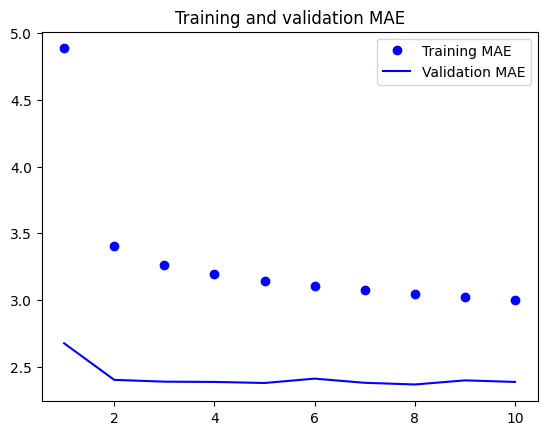

In [34]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [35]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(16, recurrent_dropout=0.2, unroll=True)(inputs)

**<h3>Stacking recurrent layers</h3>**

**Training and evaluating a dropout-regularized, stacked GRU model- Not needed**

In [36]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.x",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 383s 463ms/step - loss: 25.7442 - mae: 3.7359 - val_loss: 9.5278 - val_mae: 2.3955
Epoch 2/10
819/819 [==============================] - 378s 461ms/step - loss: 13.9171 - mae: 2.8935 - val_loss: 8.7195 - val_mae: 2.2905
Epoch 3/10
819/819 [==============================] - 374s 457ms/step - loss: 13.2817 - mae: 2.8231 - val_loss: 8.8984 - val_mae: 2.3159
Epoch 4/10
819/819 [==============================] - 377s 461ms/step - loss: 12.6723 - mae: 2.7643 - val_loss: 8.5117 - val_mae: 2.2645
Epoch 5/10
819/819 [==============================] - 375s 458ms/step - loss: 12.2197 - mae: 2.7141 - val_loss: 8.6371 - val_mae: 2.2822
Epoch 6/10
819/819 [==============================] - 375s 458ms/step - loss: 11.7325 - mae: 2.6616 - val_loss: 9.0479 - val_mae: 2.3340
Epoch 7/10
819/819 [==============================] - 373s 456ms/step - loss: 11.4305 - mae: 2.6266 - val_loss: 8.6479 - val_mae: 2.2850
Epoch 8/10
819/819 [=====================

405/405 [==============================] - 28s 67ms/step - loss: 9.3932 - mae: 2.3952
Test MAE: 2.40


**<h2>Using bidirectional RNNs</h2>**
**Training and evaluating a bidirectional LSTM**

In [37]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/10
819/819 [==============================] - 18s 19ms/step - loss: 23.4811 - mae: 3.5134 - val_loss: 10.6713 - val_mae: 2.5268
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 9.6570 - mae: 2.4250 - val_loss: 9.4609 - val_mae: 2.3898
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 8.8678 - mae: 2.3222 - val_loss: 9.7699 - val_mae: 2.4287
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 8.2811 - mae: 2.2375 - val_loss: 9.9586 - val_mae: 2.4562
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 7.6443 - mae: 2.1509 - val_loss: 10.4672 - val_mae: 2.5047
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 7.2890 - mae: 2.1026 - val_loss: 11.1467 - val_mae: 2.5802
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 7.0678 - mae: 2.0719 - val_loss: 10.9715 - val_mae: 2.5593
Epoch 8/10
819/819 [==============================] - 14s

In [38]:
### Combination of 1D Convent and dropout-regularized LSTM

combined = layers.concatenate([conv_x, lstm_x])
outputs = layers.Dense(1)(combined)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)
test_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {test_mae:.2f}")

Epoch 1/5
819/819 [==============================] - 19s 19ms/step - loss: 6.3800 - mae: 1.9726 - val_loss: 10.3770 - val_mae: 2.4896
Epoch 2/5
819/819 [==============================] - 15s 18ms/step - loss: 6.2980 - mae: 1.9601 - val_loss: 10.7828 - val_mae: 2.5360
Epoch 3/5
819/819 [==============================] - 14s 17ms/step - loss: 6.2092 - mae: 1.9467 - val_loss: 10.7261 - val_mae: 2.5309
Epoch 4/5
819/819 [==============================] - 15s 18ms/step - loss: 6.1339 - mae: 1.9345 - val_loss: 11.3614 - val_mae: 2.5968
Epoch 5/5
405/405 [==============================] - 4s 9ms/step - loss: 12.2236 - mae: 2.7208
Test MAE: 2.72


**Plotting results of the combination**


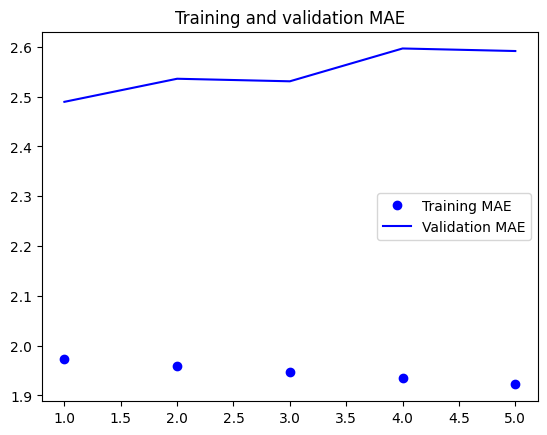

In [39]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()